# We show the basic functionalities of the differential drive vehicle model

In [26]:
from dymoesco.dynamics.diffdrive import DiffDrive
from dymoesco.control.misc_controllers import generate_smooth_control
from dymoesco.estimation.filters import EKF, calc_jacobian
import numpy as np
from autograd import jacobian
import matplotlib.pyplot as plt
import matplotlib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Parameters
t_span = (0,25)
dt = 0.1
t = np.arange(*t_span, dt)

umax = np.array([2,5])
umin = np.array([1,-5])
u_std = np.array([0.5, 0.25])

rng = np.random.default_rng(0)

### We first look at the model analytically

The continuous time dynamics are
\begin{align}
\dot{x} &= v\cos(\theta) \\
\dot{y} &= v\cos(\theta) \\
\dot{\theta} &= w/R
\end{align}

which evolve on SE(2), where $(x,y)$ is the robot's position and $\theta$ it's angle. The inputs are forward velocity $v$ and angular velocity $w$, and $R$ is the radius of the wheels.

We discretize the continuous time dynamics to get
\begin{align}
x_{k+1} &= x_k + v_k dt \cos\theta_k \\
y_{k+1} &= y_k + v_k dt \sin\theta_k \\
\theta_{k+1} &= \theta_k + w_k dt
\end{align}

For the EKF, we need to linearize these dynamics around $\hat{x}_k$, $\hat{y}_k$, $\hat{\theta}_k$:
\begin{align}
x_{k+1} &= x_k 
             + v_k dt \left(\cos\hat{\theta}_k - \sin\hat{\theta}_k (\theta_k - \hat{\theta}_k) \right) \\
        &= x_k 
             - v_k dt \sin(\hat{\theta}_k) \theta_k 
             + \left( \cos\hat{\theta}_k - \hat{\theta}_k \sin\hat{\theta}_k  \right) dt \, v_k \\
y_{k+1} &= y_k dt
             + v_k \left(\sin\hat{\theta}_k + \cos\hat{\theta}_k(\theta_k - \hat{\theta}_k)\right) \\
        &= y_k 
             + v_k dt \cos(\hat{\theta}_k) \theta_k 
             + \left( \sin\hat{\theta}_k - \hat{\theta}_k \cos\hat{\theta}_k \right) dt \, v_k \\
\theta_{k+1} &= \theta_k + dt \, w_k 
\end{align}

which we can write concisely as
$$
\begin{bmatrix} x_{k+1} \\ y_{k+1} \\ \theta_{k+1} \end{bmatrix}
=
\underbrace{\begin{bmatrix} 1 & & -v_k dt \sin \hat{\theta}_k \\
                  & 1 & v_k dt \cos \hat{\theta}_k \\
                  & & 1
\end{bmatrix}}_A
\begin{bmatrix} x_k \\ y_k \\ \theta_k \end{bmatrix}
+
\underbrace{\begin{bmatrix} \left(\cos\hat{\theta}_k - \hat{\theta}_k \sin\hat{\theta}_k \right) dt & 0 \\
                \left(\sin\hat{\theta}_k - \hat{\theta}_k \cos\hat{\theta}_k \right) dt & 0 \\
                0 & dt
\end{bmatrix}}_B
\begin{bmatrix} v_k \\ w_k \end{bmatrix}
$$

In [15]:
# Differential Drive Model
dd = DiffDrive(radius=1)
ddd = dd.discretize(dt=0.05)

In [16]:
# We can use autograd to calculate A and B numerically at specific x and u values
# EKF does this for us.
x = np.array([0.,0.,0.])
u = np.array([1.,0.])
print("A:")
print(jacobian(ddd._f)(x, u))
print("B:")
print(jacobian(ddd._f,1)(x, u))

A:
[[1.   0.   0.  ]
 [0.   1.   0.05]
 [0.   0.   1.  ]]
B:
[[0.05 0.  ]
 [0.   0.  ]
 [0.   0.05]]


Now assuming our controls are noisy, 
$$v = \hat{v} + \epsilon_v \\
  w = \hat{w} + \epsilon_w$$
where $(\hat{v},\hat{w})$ are the nominal controls sent to the robot and $\epsilon_v \sim N(0, \sigma_v)$ and $\epsilon_w \sim N(0, \sigma_w)$.

The dynamics above now look like

\begin{align}
\begin{bmatrix} x_{k+1} \\ y_{k+1} \\ \theta_{k+1} \end{bmatrix}
&=
A
\begin{bmatrix} x_k \\ y_k \\ \theta_k \end{bmatrix}
+
B
\begin{bmatrix} \hat{v}_k + \epsilon_v \\ \hat{w}_k + \epsilon_w \end{bmatrix} \\
&=
A
\begin{bmatrix} x_k \\ y_k \\ \theta_k \end{bmatrix}
+
B
\begin{bmatrix} \hat{v}_k \\ \hat{w}_k \end{bmatrix} + \epsilon_k
\end{align}

where $\epsilon_k \sim N(0, Q)$ and
\begin{align}
Q &= B \begin{pmatrix} \sigma_v^2 & 0 \\ 0 & \sigma_w^2 \end{pmatrix} B^T \\
  & = \begin{pmatrix} \sigma_v^2 \left( \cos\hat\theta_k - \hat\theta_k \sin\hat{\theta}_k  \right)^2 dt^2  & 
                   \sigma_v^2 \left( \cos\hat\theta_k - \hat\theta_k \sin\hat{\theta}_k  \right)                     
                   \left(\sin\hat{\theta}_k + \cos\hat{\theta}_k(\theta_k - \hat{\theta}_k)\right) dt^2 & 0 \\ 
       \sigma_v^2 \left( \cos\hat\theta_k - \hat\theta_k \sin\hat{\theta}_k  \right)                     
                   \left(\sin\hat{\theta}_k + \cos\hat{\theta}_k(\theta_k - \hat{\theta}_k)\right) dt^2 & 
                   \sigma_v^2 \left(\sin\hat{\theta}_k + \cos\hat{\theta}_k(\theta_k - \hat{\theta}_k)\right)^2 dt^2 & 0 \\
        0 & 0 & \sigma_w^2 dt^2
      \end{pmatrix}
\end{align}

Normally we would have to enter this by hand, but once again autograd can compute B numerically and so compute this matrix (which changes at every timestep!) for us.

In [17]:
# We can also compute the jacobian of the observation
jacobian(dd._g)(np.zeros(3))

array([[nan, nan,  0.],
       [nan, nan,  0.]])

In [34]:
import autograd.numpy as np
def _g(z):
    if np.linalg.norm(z[:2]) < 1:
        if np.linalg.norm(z[:2]) < 1e-10:
            range_ = 0.0
        else:
            range_ = np.linalg.norm(z[:2])
        bearing = np.arctan2(z[1],z[0])
        return np.array([range_, bearing])
    return None
calc_jacobian(_g, np.array([0.5,0.2,1]))

array([[ 0.92860454,  0.37219054,  0.        ],
       [-0.68846805,  1.72294798,  0.        ]])

### And then generate a trajectory from it following a random control input

In [5]:
# random control sequence
u = generate_smooth_control(umin, umax, t_span, dt, rng = rng)
# Generate trajectory
traj = dd.simulate(u, t_span, [0,0,0], np.arange(*t_span,dt))

<AxesSubplot:title={'center':'State Trajectory'}, xlabel='Time'>

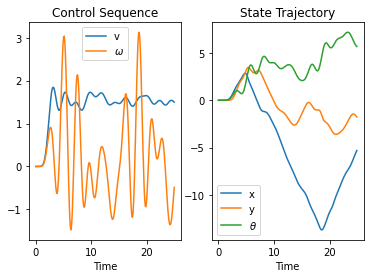

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2)
dd.plotu(traj, ax=ax1)
dd.plotx(traj, ax=ax2)

<IPython.core.display.Javascript object>


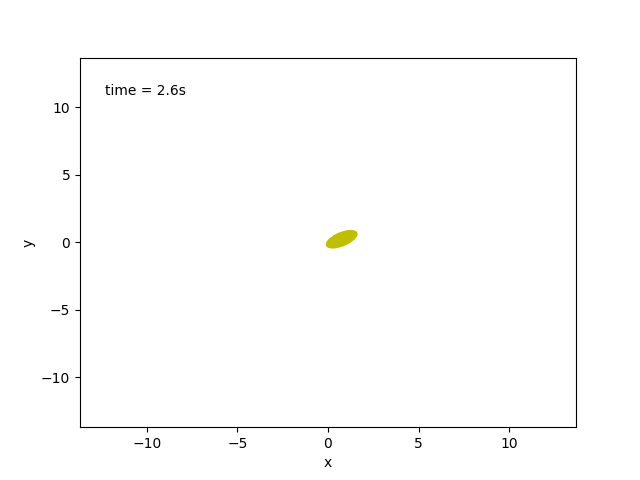

In [7]:
%matplotlib notebook
ani = dd.animate(traj)

### And finally filter this trajectory using an EKF

In [9]:
v_std = 0.5
w_std = 0.25
u_std = np.array([v_std, w_std])
y_std = 0.1
R = y_std * np.eye(3)
EKF = ddd.make_EKF(u_std, R)

In [18]:
x0 = [0., 0., 0.]
P0 = np.eye(3)
u0 = [1., 0.]
EKF.predict(x0, P0, u0)

(array([0.05, 0.  , 0.  ]),
 array([[1.000625  , 0.        , 0.        ],
        [0.        , 1.0025    , 0.05      ],
        [0.        , 0.05      , 1.00015625]]))

In [23]:
np.arctan2(-3,0)

-1.5707963267948966

0.7853981633974483